In [1]:
# !wget https://raw.githubusercontent.com/korquad/korquad.github.io/master/dataset/KorQuAD_v1.0_train.json -O KorQuAD_v1.0_train.json
# !wget https://raw.githubusercontent.com/korquad/korquad.github.io/master/dataset/KorQuAD_v1.0_dev.json -O KorQuAD_v1.0_dev.json

In [1]:
import os
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"]="1"

import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import json
from datasets import load_dataset
from sklearn.model_selection import train_test_split

from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from unsloth.chat_templates import train_on_responses_only

from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
with open('./KorQuAD_v1.0_dev.json', 'r') as f:
    dev_data = json.load(f)

with open('./KorQuAD_v1.0_train.json', 'r') as f:
    train_data = json.load(f)

In [3]:
def korquad_to_dataframe(data):
    rows = []
    for paragraph in data['data']:
        paragraph_title = paragraph['title']

        for qa in paragraph['paragraphs']:
            context = qa['context']

            for question in qa['qas']:
                q = question['question']
                qa_id = question['id']

                for answer in question['answers']:
                    a = answer['text']
                    rows.append({
                        'question': q,
                        'answer': a,
                        'qa_id': qa_id,
                        'context': context,
                        'paragraph_title': paragraph_title
                    })

    return pd.DataFrame(rows)

In [4]:
df_dev = korquad_to_dataframe(dev_data)
df_dev = df_dev.sample(frac=1).reset_index(drop=True)
print(df_dev.shape)
df_dev.head()

(5774, 5)


,question,answer,qa_id,context,paragraph_title
0,명예의 전당에 들어가려면 은퇴 후 몇년이 지나야 하는가?,5년,6469691-2-1,"300 승은 야구 명예의 전당에 들어갈 수 있는 보증 수표처럼 여겨지는데, 이 투수...",300_승_클럽
1,윤상이 나레이션을 맡은 EBS 다큐프라임 제목은 무엇인가?,한국의 강,5835201-5-2,2010년 3월에는 뉴욕에서 대학원을 졸업하고 유학 생활을 정리한 뒤 귀국하여 상명...,윤상
2,안전기술의 원전 확장을 위해 개발되는 것은?,상용경수로,6588949-2-1,미래전략기술 개발을 위해서 먼저 신기술 융합·접목을 통한 새로운 원자력 영역 개척이...,원자력진흥종합계획
3,이명박이 군대 입대 후 훈련소에서 강제 퇴소 당한 이유는?,기관지확장증,6545197-0-0,이태원시장에서 매일 새벽 청소 일을 하는 환경미화원으로 학업을 이어가던 중 생활고를...,이명박
4,1970년 네덜란드 그랑프리에서 사망한 선수는?,피어스 커리지,6464976-3-0,하지만 언제나 순조롭지만은 않았다. 1970년 피어스 커리지(Piers Courag...,뉘르부르크링


In [5]:
df_train = korquad_to_dataframe(train_data)
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(df_train.shape)
df_train.head()

(60407, 5)


,question,answer,qa_id,context,paragraph_title
0,Hilberg은 유대인 박해를 통해 설명할 수 있는 유대인들의 성향을 무엇이라고 했는가?,순응적인 태도,6571960-23-1,Peter Longerich 역시 막대한 연구 끝에 “유대인들은 실질적으로 어떠한 ...,홀로코스트
1,야금 연구소가 중성자 감속재로 사용한 것은?,흑연,6502200-4-0,"한편, 핵반응 기술에 대한 연구 역시 두 가지로 나뉘었다. 컬럼비아 대학교의 해럴드...",맨해튼_계획
2,2007년 8월 15일 아유가 프로리그 데뷔전을 치룰 때 누구와 교체되어 경기에 투...,모드스트 음바미,6539928-1-0,2007년 8월 15일 발랑시엔전에서 모드스트 음바미와 89분에 교체되어 프로리그 ...,앙드레_아유
3,베일이 아스널과 경기했던 때는?,2010년 4월,6473562-3-1,베일은 인상적인 활약을 계속해 나가며 풀럼과의 FA컵 6라운드 재경기에서 3-1 승...,가레스_베일
4,맨체스터 시티가 2009-10 시즌 개막전에서 이긴 팀은?,블랙번 로버스,6529318-14-1,맨체스터 시티는 그 시즌 결국 리그 10위로 마감하였고 휴스는 팀을 더욱더 강화시키...,맨체스터_시티_FC


In [6]:
df_train = df_train[['question', 'context', 'answer']]
df_dev = df_dev[['question', 'context', 'answer']]

df = pd.concat([df_train, df_dev], axis=0).reset_index(drop=True)
df.isnull().value_counts()

question  context  answer
False     False    False     66181
Name: count, dtype: int64

In [7]:
max_seq_length = 2048 # Choose any! We auto support = Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.10.7: Fast Llama patching. Transformers = 4.46.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.65 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [31]:
lora_model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # choose any number > 0; Suggested 8, 16, 32, 64, 128 (LoRA Rank)
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth", # "unsloth" or "True",
    random_state = 3407,
    use_rslora = False, # support rank static LoRA,
    loftq_config = None, # And LoftQ
)

In [9]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=3072, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=3072, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
              (default): I

In [10]:
lora_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
      

In [11]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def format_example(row):
    prompt = f"""{row["question"]}

Information

###
{row["context"]}
###"""

    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question"
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["answer"]}
    ]

    return tokenizer.apply_chat_template(messages, tokenize=False)

In [12]:
df['text'] = df.apply(format_example, axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,question,context,answer,text
0,방위비분담협정은 어디까지나 주한미군 주둔 비용에 관한 협상이라고 선을 그은 나라는?,4월에도 협상이 이어져 11일 ~ 12일 제주특별자치도에서 2차 회의가 진행되었다....,한국,<|begin_of_text|><|start_header_id|>system<|en...
1,1361년 기존의 법이 강화되어 추가된 벌칙을 쓰시오.,당국은 긴급 법안(1349년의 노동자 조례와 1351년의 노동자 법령)을 통과시킴으...,단근질과 투옥,<|begin_of_text|><|start_header_id|>system<|en...
2,마리우스가 로마로 진격한 시기는 언제인가?,로마에서는 술라를 지지하는 보수파들과 루키우스 코르넬리우스 킨나를 지지하는 민중파 ...,기원전 87년 말,<|begin_of_text|><|start_header_id|>system<|en...
3,문벌 출신들이 받았던 특혜는?,문벌 출신은 유리한 교육상의 여건으로 다수의 과거 합격자를 배출하였다. 또한 이들은...,음서,<|begin_of_text|><|start_header_id|>system<|en...
4,조비의 소문을 이용하여 황제가 된 인물은?,"조비는 220년 정월 조조의 죽음으로 위왕의 자리를 이어받았고, 조조의 지위를 승계...",유비(劉備),<|begin_of_text|><|start_header_id|>system<|en...


In [13]:
# system 프롬프트에 
# Cutting Knowledge Date: December 2023
# Today Date: 26 July 2024 가 추가되어 llama 3.1 프롬프트 탬플릿임을 확인

print(df.loc[0,'text'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

방위비분담협정은 어디까지나 주한미군 주둔 비용에 관한 협상이라고 선을 그은 나라는?

Information

###
4월에도 협상이 이어져 11일 ~ 12일 제주특별자치도에서 2차 회의가 진행되었다. 트럼프는 줄기차게 언급했던 안보 무임승차론을 제기하면서 전략자산 전개 비용을 한국이 부담해야 한다고 주장했으나 한국은 "방위비분담협정은 어디까지나 주한미군 주둔 비용에 관한 협상"이라고 선을 그었다. 외교부 관계자는 "(1차 회의에 비해) 진전됐다기보다 서로 자신의 주장에 대한 근거나 배경을 깊이있게 얘기했다"고 언급해 아직 이견이 크다는 것을 확인했으며, 배치 비용을 미국이 부담하는 것으로 합의한 사드 문제는 논의되지 않았다. 5월 14일 ~ 15일에는 미국 국무부 청사에서 3차 회의가 열렸다. 전략자산 전개 비용의 한국 부담 요청에 더해 미국은 방위비 분담이 현금 지원에서 현물 중심으로 개선되는 지금의 흐름이 후퇴해선 안 된다는 입장도 덧붙여서 "아직 갈 길이 멀다"는 평가다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

한국<|eot_id|>


In [14]:
def count_tokens(row):
    return len(
        tokenizer(
            row['text'],
            add_special_tokens=True,
            return_attention_mask=False
        )["input_ids"]
    )

In [15]:
%%time
df["token_count"] = df.apply(count_tokens, axis=1)

CPU times: user 37.9 s, sys: 16.7 ms, total: 37.9 s
Wall time: 37.9 s


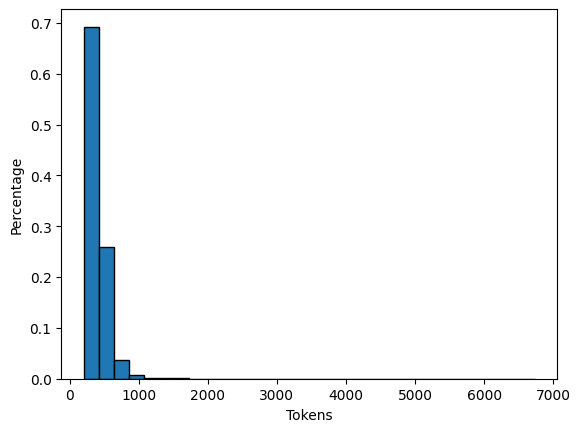

(57139, 66181, 0.8633746845771445)

In [16]:
df.head()
plt.hist(df['token_count'], ec='k', bins=30, weights=np.ones(len(df['token_count'])) / len(df['token_count']) )
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show()

len(df[df['token_count'] < 512]), len(df), len(df[df['token_count'] < 512]) / len(df)

In [17]:
SEED = 42

# 토큰 길이로 적당히 학습 샘플 서브샘플링 
df_sampled = df[df["token_count"] < 512]
df_sampled = df_sampled.sample(6000, random_state=SEED)
df_sampled.shape

(6000, 5)

In [18]:
train, temp = train_test_split(df_sampled, test_size=0.2, random_state=SEED)
val, test = train_test_split(temp, test_size=0.2, random_state=SEED)

In [19]:
print(f"Train data ratio:{len(train) / len(df_sampled)}, {len(train)}")
print(f"Valid data ratio:{len(val) / len(df_sampled)}, {len(val)}")
print(f"Test data ratio:{len(test) / len(df_sampled)}, {len(test)}")

Train data ratio:0.8, 4800
Valid data ratio:0.16, 960
Test data ratio:0.04, 240


In [20]:
train.sample(n=4000, random_state=SEED).to_json("train.json", orient="records", lines=True)
val.sample(n=500, random_state=SEED).to_json("val.json", orient="records", lines=True)
test.sample(n=100, random_state=SEED).to_json("test.json", orient="records", lines=True)

In [21]:
dataset = load_dataset(
    "json",
    data_files={
        "train": "train.json",
        "validation": "val.json",
        "test": "test.json"
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 500
    })
    test: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 100
    })
})

In [23]:
def create_test_prompt(data_row):
    prompt = f"""{data_row["question"]}

Information

###
{data_row["context"]}
###"""

    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question"
        },
        {"role": "user", "content": prompt},
    ]

    return tokenizer.apply_chat_template(
        messages, tokenize=False,
        add_generation_prompt=True
    ) # 프롬프트 끝에 <|start_header_id|>assistant<|end_header_id|> 를 붙이게 됨

In [24]:
# 테스트 셋에 대해서 학습전 출력을 확인
def inf_test_one_sample(example, model):
    prompt = create_test_prompt(example)
    print("\nPROMPT\n", prompt.strip())
    
    inputs = torch.tensor([tokenizer(prompt)['input_ids']]).to('cuda')

    outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)

    print("\nANS\n", example['answer'])
    print("\nPRED\n", tokenizer.batch_decode(outputs)[0].split('<|start_header_id|>assistant<|end_header_id|>')[1].strip())

    return example['answer'], tokenizer.batch_decode(outputs)[0].split('<|start_header_id|>assistant<|end_header_id|>')[1].strip()

FastLanguageModel.for_inference(model);
untrained = []

In [25]:
# Append
untrained.append(
    inf_test_one_sample(dataset['test'][0], model)
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

리옹 지하철의 시간 당 이용객 수는 약 몇 명인가?

Information

###
가장 많은 승객을 빠르게 이동시킬 수 있는 수단으로는 지하철이 있다. 다른 교통수단과 비교해볼때 지하철의 최대 장점은 단위시간당 수송인원이 많다는 것이다. 65명이 탑승하고 10분마다 운행하는 버스의 시간당 승객 수송량은 390명이다. 200명이 탑승하고 10분마다 운행하는 트램의 시간당 승객 수송량은 1200명이다. 600명이 탑승하고, 2분마다 운행하는 지하철의 시간당 승객 수송량은 18,000명이다. 이러한 수송량 때문에 전 세계적으로 지하철이 없는 대도시는 찾아보기 어렵다. 프랑스 리옹에서는 시간당 약 1만명이 지하철을 이용한다. 지하철의 시간당 수송 인원이 많은 이유는 전용 철로를 이용해 다니기 때문이다. 운행에 방해가 될만한 것이 없어 평균속도 75km로 달릴 수 있다. 극심한 혼잡이 빚어지는 출퇴근시간에는 2분에 한대꼴로 운행이 되기도 한다. 하지만 지하철 인프라를 구축하는데 많은 시간과 돈이 든다. 터널을 뚫고 레일을 깔고, 엘리베이터, 계단, 승강장 등을 만들어야 하기 때문에 지하철은 트램에 비해 3~5배 가량 더 많은 돈을 투자해야 한다. 건설비는 지자체와 중앙정부, 기업들의 세금, 그리고 승객들이 내는 요금으로 차츰 충당된다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>



ANS
 약 1만명

PRED
 리옹의 시간당 이용객 수는 10,000명입니다.<|eot_id|>


In [26]:
untrained.append(
    inf_test_one_sample(dataset['test'][1], model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

소울커넥션 크리스마스 디지틀싱글 제목은?

Information

###
소울 커넥션에 입단하게 된 스틸피엠은 입단 맞이 벙개송을 시작으로 이후 활발한 활동을 펼치게 된다. 당시 힙합씬에서 크게 히트한 매슬로의 [Young MAstory] 앨범에서 그가 참여한 곡은 3곡이며 당시 입단한지 1년 정도밖에 안 지난 것을 감안하면 많은 작업량인 것을 알 수 있다. 이후 그는 소울커넥션 크리스마스 맞이 디지털 싱글 [해피 크리스마스]의 타이틀 곡 [해피 크리스마스]에 참여하게 되어 더욱 더 그를 알리게 된다. 2009년 3월 소울커넥션의 첫 컴필레이션 앨범 [RapsodY]가 발매 되었는데 이때 스틸피엠은 타이틀 곡 〈Hey ma〉를 포함 무려 7곡이나 참여하여 더욱 더 소울 커넥션 내 그의 위치를 리스너들에게 각인 시켰다. 이후 소울커넥션과 Day life의 콜라보 앨범 [Day life]에서 그는 전곡에 참여하여 완전히 메인 멤버로 부상하게 된다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 [해피 크리스마스]

PRED
 소울커넥션 크리스마스 디지틀싱글의 제목은 해피 크리스마스입니다.<|eot_id|>


In [27]:
untrained.append(
    inf_test_one_sample(dataset['test'][2], model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

토트넘과 유로파리그에서 경기한 상대는 누구인가?

Information

###
2013년 3월 3일, 베일은 토트넘이 2-1로 이긴 아스널과의 북런던 더비 경기에서 득점을 기록했다. 3월 7일, 토트넘은 UEFA 유로파리그에서 인테르나치오날레를 상대했고, 베일이 토트넘의 선제골을 넣는 것을 시작으로 3-0 대승을 거두었다. 베일은 2013년 초반에 맹활약을 이어나가 2월 프리미어리그 이달의 선수상을 받은 것은 물론, BBC로부터 이 달의 골 1월과 2월에 모두 득점자로도 선정되었는데, 그는 각각 노리치 시티전과 웨스트 햄 유나이티드전에서의 득점으로 선정되었다. 4월 4일, 베일은 바젤과의 UEFA 유로파리그 8강전에서 오른쪽 발목 부상을 당했다. 부상에서 돌아온 베일은 맨체스터 시티와의 홈경기에서 자신의 득점과 클린트 뎀프시의 골을 돕는 도움을 기록했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 인테르나치오날레

PRED
 UEFA 유로파 리그에서 토트넘과 경기한 상대는 인테르나치오날레가 아니었으며, 그 경기 결과는 3-0로 토트넘이 승리했다. 인테르나치오날레는 8강전에서 토트�


In [28]:
untrained.append(
    inf_test_one_sample(dataset['test'][3], model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

역세권 개발이 미뤄진 이유는?

Information

###
이후 2007년 9월 27일, (가칭)북창원역을 비롯한 용동 일원의 규모의 북창원역 역세권 종합개발 사업을 추진할 것을 발표하여 이날 박완수 창원시장과 신희범 경상남도개발공사 사장이 상호 분담을 통하여 효율적으로 추진할 것을 골자로 하는 시정협약을 체결하였다. 이 종합개발 사업에는 고속철도 개통으로 예상되는 (가칭)북창원역 진입로 개선 문제와 함께, 정병산과 비음산을 찾는 시민들의 주차공간을 확보하고 여러 상업, 공공기관 등을 주변에 배치하여 공간체계의 효율성 등을 개선 할 수 있도록 하였다. 구체적으로는 역이 신설되는 용동저수지 일원 295,110m에 1,149억원의 예산을 투입하여, 그 가운데 절반에 해당하는 15만 2천여m에 도시기반시설을, 6만 1천여m은 상업용지로, 나머지 8만 1천여m는 기타시설용지로 구분하여 역세권개발이 추진되었다. 2007년 시행협약을 했던 당시에 이 사업은 2010년 초에 착공하여 2011년 말 경에 완공 될 예정이었지만, 그린벨트 해제에 시간이 오래 걸리면서2012년에 착공하여 2014년에 완공으로 계획이 변경되었고, 사업 시기도 2년 이상 차질을 빚었다. 이에 박완수 창원시장은 역세권 개발에 대해 특별한 대책을 강구해야 한다고 말했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 그린벨트 해제

PRED
 역세권 개발이 미뤄 진 이유는 북창원역 surrounding developmen

In [29]:
untrained

[('약 1만명', '리옹의 시간당 이용객 수는 10,000명입니다.<|eot_id|>'),
 ('[해피 크리스마스]', '소울커넥션 크리스마스 디지틀싱글의 제목은 해피 크리스마스입니다.<|eot_id|>'),
 ('인테르나치오날레',
  'UEFA 유로파 리그에서 토트넘과 경기한 상대는 인테르나치오날레가 아니었으며, 그 경기 결과는 3-0로 토트넘이 승리했다. 인테르나치오날레는 8강전에서 토트�'),
 ('그린벨트 해제',
  '역세권 개발이 미뤄 진 이유는 북창원역 surrounding development를 추진하기 위하여였습니다.<|eot_id|>')]

In [33]:
FastLanguageModel.for_inference(lora_model);
FastLanguageModel.for_training(lora_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
      

In [34]:
# Define the Trainer 
trainer = SFTTrainer(
    model = lora_model,
    tokenizer = tokenizer,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 1,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps",
        eval_steps=0.2,
        save_steps=0.2,
    ),
)

trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/home/mgyukim/.conda/envs/Llama/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [35]:
print(tokenizer.decode(trainer.train_dataset[5]["input_ids"]))

# trainer.train_dataset의 labels에는 instruction에 해당하는 입력부분은 모두 -100으로
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
print(tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

통일민주당을 장학하고 대통령 선거 출마 선언을 한 사람은?

Information

###
9월 29일에는 김영삼 총재, 김대중 고문 간 후보단일화 회담을 하였으나 이견차이를 좁히지 못하고 결렬되었다. 9월 30일 김대중은 다시 제13대 대통령 선거 후보 출마를 김영삼과 야당 후보단일화 협상을 벌였으나 양자간의 시각차이만 확인하고 결렬되었다. 재야 인사들의 통합 요청에도 불구하고 협상이 결렬되자, 이는 군사 정권 후계자를 놓고 야당 지도자간 분열했다 하여 적전 분열이라는 비판을 초래하였다. 10월 10일, 통일민주당을 장악한 김영삼은 대통령 선거 출마를 발표하고 나서자 당내 경선에서 절대적으로 불리한 위치에 놓여있던 김대중은 10월 18일 통일민주당을 탈당하였다. 11월 12일에는 평화민주당을 창당해 대표 겸 13대 대통령 후보로 선출된 이후 야당 후보였던 김영삼과 후보 단일화를 이루지 못한 채 12월 16일에 제13대 대통령 선거에 출마했지만, 노태우와 김영삼에게 밀려 611만 표를 얻고 낙선했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

김영삼<|eot_id|>
                                                                                                                                                                                               

In [36]:
# 학습 시작
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 500
 "-____-"     Number of trainable parameters = 24,313,856
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: callingu (3d_nerf). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
100,0.163000,0.223015
200,0.162000,0.184050
300,0.078600,0.167549
400,0.188000,0.158417
500,0.041400,0.157640


In [38]:
trained = []
FastLanguageModel.for_inference(lora_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
      

In [39]:
trained.append(
    inf_test_one_sample(dataset['test'][0], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

리옹 지하철의 시간 당 이용객 수는 약 몇 명인가?

Information

###
가장 많은 승객을 빠르게 이동시킬 수 있는 수단으로는 지하철이 있다. 다른 교통수단과 비교해볼때 지하철의 최대 장점은 단위시간당 수송인원이 많다는 것이다. 65명이 탑승하고 10분마다 운행하는 버스의 시간당 승객 수송량은 390명이다. 200명이 탑승하고 10분마다 운행하는 트램의 시간당 승객 수송량은 1200명이다. 600명이 탑승하고, 2분마다 운행하는 지하철의 시간당 승객 수송량은 18,000명이다. 이러한 수송량 때문에 전 세계적으로 지하철이 없는 대도시는 찾아보기 어렵다. 프랑스 리옹에서는 시간당 약 1만명이 지하철을 이용한다. 지하철의 시간당 수송 인원이 많은 이유는 전용 철로를 이용해 다니기 때문이다. 운행에 방해가 될만한 것이 없어 평균속도 75km로 달릴 수 있다. 극심한 혼잡이 빚어지는 출퇴근시간에는 2분에 한대꼴로 운행이 되기도 한다. 하지만 지하철 인프라를 구축하는데 많은 시간과 돈이 든다. 터널을 뚫고 레일을 깔고, 엘리베이터, 계단, 승강장 등을 만들어야 하기 때문에 지하철은 트램에 비해 3~5배 가량 더 많은 돈을 투자해야 한다. 건설비는 지자체와 중앙정부, 기업들의 세금, 그리고 승객들이 내는 요금으로 차츰 충당된다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 약 1만명

PRED
 1만명<|eot_id|>


In [40]:
trained.append(
    inf_test_one_sample(dataset['test'][1], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

소울커넥션 크리스마스 디지틀싱글 제목은?

Information

###
소울 커넥션에 입단하게 된 스틸피엠은 입단 맞이 벙개송을 시작으로 이후 활발한 활동을 펼치게 된다. 당시 힙합씬에서 크게 히트한 매슬로의 [Young MAstory] 앨범에서 그가 참여한 곡은 3곡이며 당시 입단한지 1년 정도밖에 안 지난 것을 감안하면 많은 작업량인 것을 알 수 있다. 이후 그는 소울커넥션 크리스마스 맞이 디지털 싱글 [해피 크리스마스]의 타이틀 곡 [해피 크리스마스]에 참여하게 되어 더욱 더 그를 알리게 된다. 2009년 3월 소울커넥션의 첫 컴필레이션 앨범 [RapsodY]가 발매 되었는데 이때 스틸피엠은 타이틀 곡 〈Hey ma〉를 포함 무려 7곡이나 참여하여 더욱 더 소울 커넥션 내 그의 위치를 리스너들에게 각인 시켰다. 이후 소울커넥션과 Day life의 콜라보 앨범 [Day life]에서 그는 전곡에 참여하여 완전히 메인 멤버로 부상하게 된다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 [해피 크리스마스]

PRED
 해피 크리스마스<|eot_id|>


In [41]:
trained.append(
    inf_test_one_sample(dataset['test'][2], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

토트넘과 유로파리그에서 경기한 상대는 누구인가?

Information

###
2013년 3월 3일, 베일은 토트넘이 2-1로 이긴 아스널과의 북런던 더비 경기에서 득점을 기록했다. 3월 7일, 토트넘은 UEFA 유로파리그에서 인테르나치오날레를 상대했고, 베일이 토트넘의 선제골을 넣는 것을 시작으로 3-0 대승을 거두었다. 베일은 2013년 초반에 맹활약을 이어나가 2월 프리미어리그 이달의 선수상을 받은 것은 물론, BBC로부터 이 달의 골 1월과 2월에 모두 득점자로도 선정되었는데, 그는 각각 노리치 시티전과 웨스트 햄 유나이티드전에서의 득점으로 선정되었다. 4월 4일, 베일은 바젤과의 UEFA 유로파리그 8강전에서 오른쪽 발목 부상을 당했다. 부상에서 돌아온 베일은 맨체스터 시티와의 홈경기에서 자신의 득점과 클린트 뎀프시의 골을 돕는 도움을 기록했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 인테르나치오날레

PRED
 인테르나치오날레<|eot_id|>


In [42]:
trained.append(
    inf_test_one_sample(dataset['test'][3], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

역세권 개발이 미뤄진 이유는?

Information

###
이후 2007년 9월 27일, (가칭)북창원역을 비롯한 용동 일원의 규모의 북창원역 역세권 종합개발 사업을 추진할 것을 발표하여 이날 박완수 창원시장과 신희범 경상남도개발공사 사장이 상호 분담을 통하여 효율적으로 추진할 것을 골자로 하는 시정협약을 체결하였다. 이 종합개발 사업에는 고속철도 개통으로 예상되는 (가칭)북창원역 진입로 개선 문제와 함께, 정병산과 비음산을 찾는 시민들의 주차공간을 확보하고 여러 상업, 공공기관 등을 주변에 배치하여 공간체계의 효율성 등을 개선 할 수 있도록 하였다. 구체적으로는 역이 신설되는 용동저수지 일원 295,110m에 1,149억원의 예산을 투입하여, 그 가운데 절반에 해당하는 15만 2천여m에 도시기반시설을, 6만 1천여m은 상업용지로, 나머지 8만 1천여m는 기타시설용지로 구분하여 역세권개발이 추진되었다. 2007년 시행협약을 했던 당시에 이 사업은 2010년 초에 착공하여 2011년 말 경에 완공 될 예정이었지만, 그린벨트 해제에 시간이 오래 걸리면서2012년에 착공하여 2014년에 완공으로 계획이 변경되었고, 사업 시기도 2년 이상 차질을 빚었다. 이에 박완수 창원시장은 역세권 개발에 대해 특별한 대책을 강구해야 한다고 말했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 그린벨트 해제

PRED
 역세권 종합개발<|eot_id|>


In [43]:
pd.DataFrame(
    data=[(utrd[0], utrd[1], trd[1]) for utrd, trd in zip(untrained, trained)],
    columns=['정답', '학습전 출력', '학습후 출력']
)

,정답,학습전 출력,학습후 출력
0,약 1만명,"리옹의 시간당 이용객 수는 10,000명입니다.<|eot_id|>",1만명<|eot_id|>
1,[해피 크리스마스],소울커넥션 크리스마스 디지틀싱글의 제목은 해피 크리스마스입니다.<|eot_id|>,해피 크리스마스<|eot_id|>
2,인테르나치오날레,"UEFA 유로파 리그에서 토트넘과 경기한 상대는 인테르나치오날레가 아니었으며, 그 ...",인테르나치오날레<|eot_id|>
3,그린벨트 해제,역세권 개발이 미뤄 진 이유는 북창원역 surrounding development를...,역세권 종합개발<|eot_id|>
